<a href="https://colab.research.google.com/github/zhulkhoirr/Steam-Recommendation-System/blob/main/SteamRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Game Pada Platform Steam

## 1. Download Datasets Dari Kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
100% 659M/660M [00:08<00:00, 70.2MB/s]
100% 660M/660M [00:08<00:00, 78.3MB/s]


In [7]:
!unzip -q game-recommendations-on-steam.zip

## 2. Memahami Data

In [8]:
import numpy as np
import pandas as pd

In [13]:
recommendations_df = pd.read_csv('recommendations.csv')

recommendations_df.sample(5)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
21841788,10180,0,0,2014-09-04,True,1.7,4647998,21841788
10592000,440,0,0,2015-09-16,True,371.9,5669030,10592000
31204350,589780,0,0,2020-02-29,True,5.6,7145162,31204350
1049062,962130,182,20,2021-10-06,True,150.1,10648865,1049062
28570926,1122290,16,35,2019-08-31,True,0.1,4748758,28570926


## 3. Mempersiapkan Data

In [15]:
recommendations_df = pd.read_csv('recommendations.csv', usecols=['app_id', 'is_recommended', 'user_id', 'hours'])

recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
0,975370,True,36.3,51580
1,304390,False,11.5,2586
2,1085660,True,336.5,253880
3,703080,True,27.4,259432
4,526870,True,7.9,23869


In [16]:
hours_count = recommendations_df[recommendations_df['hours'] == 0.0].count()

print(f"Jumlah nilai 0.0 di kolom 'hours': {hours_count['hours']}")

Jumlah nilai 0.0 di kolom 'hours': 176329


In [17]:
recommendations_df = recommendations_df[recommendations_df['hours'] != 0.0]

In [18]:
zero_hours_count = (recommendations_df['hours'] == 0.0).sum()

print(f"Jumlah nilai 0.0 di kolom 'hours': {zero_hours_count}")

Jumlah nilai 0.0 di kolom 'hours': 0


In [19]:
n_recommendations = recommendations_df['user_id'].value_counts()
print(n_recommendations)

user_id
11764552    5652
5112758     3657
11656130    3648
5669734     3479
11553593    3118
            ... 
5586939        1
4497103        1
2719342        1
7185639        1
2306695        1
Name: count, Length: 13760373, dtype: int64


In [20]:
n_recommendations = recommendations_df['user_id'].value_counts()
recommendations_df = recommendations_df[recommendations_df['user_id'].isin(n_recommendations[n_recommendations >=50].index)].copy()
recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
58,602960,True,41.9,737481
138,570940,False,73.3,5136277
151,1196590,True,19.0,5935019
203,304390,False,42.5,10567745
209,244850,True,540.7,11143713


In [21]:
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 1


In [22]:
recommendations_df.drop_duplicates(inplace=True)
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [23]:
recommendations_df.isnull().sum()

app_id            0
is_recommended    0
hours             0
user_id           0
dtype: int64

In [24]:
recommendations_df['is_recommended'] = recommendations_df['is_recommended'].astype(int)

## 4. Preprocessing Data

In [25]:
user_ids = recommendations_df['user_id'].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded2user = {i:x for i, x in enumerate(user_ids)}
recommendations_df['user'] = recommendations_df['user_id'].map(user2user_encoded)
n_users = len(user2user_encoded)

app_ids = recommendations_df['app_id'].unique().tolist()
app2app_encoded = {x:i for i, x in enumerate(app_ids)}
app_encoded2app = {i:x for i, x in enumerate(app_ids)}
recommendations_df['app'] = recommendations_df['app_id'].map(app2app_encoded)
n_app  = len(app2app_encoded)

print("Jumlah user: {}, Jumlah game: {}".format(n_users, n_app))

Jumlah user: 36646, Jumlah game: 36028


In [26]:
recommendations_df

,app_id,is_recommended,hours,user_id,user,app
58,602960,1,41.9,737481,0,0
138,570940,0,73.3,5136277,1,1
151,1196590,1,19.0,5935019,2,2
203,304390,0,42.5,10567745,3,3
209,244850,1,540.7,11143713,4,4
...,...,...,...,...,...,...
41154764,1818450,1,1.0,13261742,24873,991
41154770,700600,1,2.0,6382076,35046,2837
41154771,362960,1,35.0,7858713,21437,3024
41154784,633230,0,20.0,8107668,18148,2391


In [27]:
recommendations_df = recommendations_df.sample(frac=1, random_state=46)

X = recommendations_df[['user', 'app']].values
y = recommendations_df['is_recommended']

In [28]:
X

array([[ 8127,    52],
       [ 5147, 27858],
       [ 6385,  2674],
       ...,
       [30719,  1078],
       [ 7675,   401],
       [23746, 25712]])

In [29]:
y

13131890    1
35625112    1
16695870    1
14523913    1
6006244     1
           ..
3402980     0
36455208    1
9328930     0
19537234    1
36598476    0
Name: is_recommended, Length: 3376881, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train set is_recommended: {}".format(len(y_train)))
print("Test set is_recommended: {}".format(len(y_test)))

Train set is_recommended: 2701504
Test set is_recommended: 675377


In [31]:
X_train

array([[29438,  3890],
       [ 3727, 23255],
       [   55,   745],
       ...,
       [  991, 27745],
       [35784, 27875],
       [25174,  1776]])

In [32]:
X_train[:, 0]

array([29438,  3727,    55, ...,   991, 35784, 25174])

In [33]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [34]:
X_train_array

[array([29438,  3727,    55, ...,   991, 35784, 25174]),
 array([ 3890, 23255,   745, ..., 27745, 27875,  1776])]

## 5. Membuat Model

In [35]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Dot, BatchNormalization

def RecommenderNet(n_users, n_app, embedding_size=32):
  user_input = Input(shape=(1), name='user')
  user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
  app_input = Input(shape=(1), name='app')
  app_embedding = Embedding(n_app, embedding_size, name='app_embedding')(app_input)

  # concatenate = Concatenate(name='concatenate')([user_vec, app_vec])
  dot = Dot(axes=1, normalize=True, name='dot')([user_embedding, app_embedding])
  flatten = Flatten(name='flatten')(dot)

  dense = Dense(128, activation='relu', name='dense')(flatten)
  dropout = Dropout(0.4, name='dropout')(dense)
  batch_norm = BatchNormalization(name='batch_norm')(dropout)
  output = Dense(1, activation='sigmoid', name='output')(batch_norm)

  model = Model([user_input, app_input], output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mse'])

  return model

model = RecommenderNet(n_users, n_app)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 app (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 32)                1172672   ['user[0][0]']                
                                                                                                  
 app_embedding (Embedding)   (None, 1, 32)                1152896   ['app[0][0]']                 
                                                                                              

In [36]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=15,
    batch_size=10000,
    validation_data=(X_test_array, y_test)
)

Epoch 1/15
271/271 [==============================] - 141s 505ms/step - loss: 0.5697 - mae: 0.3715 - mse: 0.1900 - val_loss: 0.4927 - val_mae: 0.3234 - val_mse: 0.1569
Epoch 2/15
271/271 [==============================] - 150s 555ms/step - loss: 0.4946 - mae: 0.3160 - mse: 0.1574 - val_loss: 0.4890 - val_mae: 0.3127 - val_mse: 0.1556
Epoch 3/15
271/271 [==============================] - 133s 490ms/step - loss: 0.4883 - mae: 0.3110 - mse: 0.1553 - val_loss: 0.4877 - val_mae: 0.3087 - val_mse: 0.1552
Epoch 4/15
271/271 [==============================] - 142s 526ms/step - loss: 0.4858 - mae: 0.3090 - mse: 0.1544 - val_loss: 0.4866 - val_mae: 0.3087 - val_mse: 0.1548
Epoch 5/15
271/271 [==============================] - 145s 537ms/step - loss: 0.4837 - mae: 0.3076 - mse: 0.1537 - val_loss: 0.4854 - val_mae: 0.3081 - val_mse: 0.1543
Epoch 6/15
271/271 [==============================] - 139s 516ms/step - loss: 0.4819 - mae: 0.3064 - mse: 0.1531 - val_loss: 0.4846 - val_mae: 0.3071 - val_mse:

In [37]:
loss, mae, mse = model.evaluate(X_test_array, y_test)

print(f'Loss: {loss}, MAE: {mae}, MSE: {mse}')

21106/21106 [==============================] - 93s 4ms/step - loss: 0.4808 - mae: 0.3033 - mse: 0.1528
Loss: 0.48082664608955383, MAE: 0.3033131957054138, MSE: 0.15280361473560333


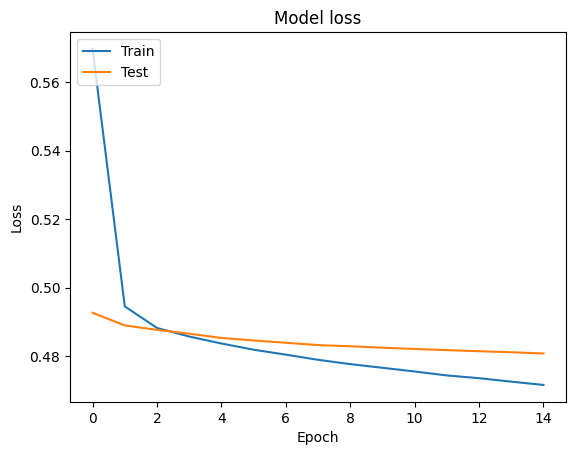

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
model.save('model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Metadata Game Steam

In [41]:
games_df = pd.read_csv('games.csv')

games_df.sample(5)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
28038,1344820,Stargaze,2020-11-20,True,False,False,Positive,84,13,19.99,19.99,0.0,True
30304,274121,Call of Duty®: Black Ops II - Beast Personaliz...,2014-04-03,True,False,False,Positive,82,17,1.99,1.99,0.0,True
1836,1337100,Warhammer Age of Sigmar: Tempestfall,2021-11-17,True,False,False,Mixed,68,164,17.99,29.99,40.0,True
39797,1311740,Boreal Tenebrae Act I: “I Stand Before You A ...,2020-05-19,True,False,False,Positive,88,34,6.99,6.99,0.0,True
20960,458030,StarFringe: Adversus,2016-04-05,True,False,False,Mixed,59,32,0.99,0.99,0.0,True


In [48]:
import json

with open('games_metadata.json', 'r') as file:
    data = file.read()

json_objects = data.split('\n')

data_list = []
for obj in json_objects:
    if obj.strip():
        data_list.append(json.loads(obj))

games_metadata_df = pd.DataFrame(data_list)
games_metadata_df['tags'] = games_metadata_df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
games_metadata_df.sample(5)


,app_id,description,tags
38380,402310,Explore the shifting seas of a strange realm. ...,"RPG, Turn-Based Combat, Strategy, Indie, Rogue..."
48440,1194630,Trapped and isolated in the abandoned town of ...,"Horror, Multiple Endings, Psychological Horror..."
11823,1032590,"When you awake, you find yourself in a mansion...","Indie, Action, Adventure, RPG, Horror, Surviva..."
508,1276040,The Top 100 Movies. You know them and you love...,"Word Game, Text-Based, Trivia, Puzzle, Superhe..."
29344,555130,"The Sonic Hunter is our latest production, a k...","Indie, Casual, VR"


In [66]:
gg = games_metadata_df[games_metadata_df['app_id'] == 409710]

gg

,app_id,description,tags
25126,409710,"BioShock is a shooter unlike any other, loaded...","FPS, Story Rich, Atmospheric, Horror, Singlepl..."


In [65]:
games_with_metadata_df = pd.merge(games_df, games_metadata_df, on='app_id', how='outer')

selected_columns = ['app_id', 'title', 'rating', 'user_reviews', 'price_original', 'description', 'tags']

games_with_metadata_df = games_with_metadata_df[selected_columns]

games_with_metadata_df.sample(5)

,app_id,title,rating,user_reviews,price_original,description,tags
3448,1590561,SCARLET NEXUS Pre-Order Bundle,Mixed,25,4.99,,"Action, Adventure, RPG"
25126,409710,BioShock™ Remastered,Mostly Positive,36988,19.99,"BioShock is a shooter unlike any other, loaded...","FPS, Story Rich, Atmospheric, Horror, Singlepl..."
31281,434150,Dark Night,Mixed,20,0.99,"Welcome home Amelia, familiar eyes are watchin...","Indie, Adventure, Horror"
30548,1572920,SuperTux,Overwhelmingly Positive,661,0.00,Classic 2D jump'n'run sidescroller featuring T...,"2D Platformer, Runner, Platformer, Arcade, 2D,..."
5711,1427591,RPG Maker MV - MV Trinity Resource Pack,Positive,10,34.99,,"Design & Illustration, Web Publishing"


In [60]:
filtered_df = games_with_metadata_df[selected_columns]

sorted_df = filtered_df.sort_values(by='user_reviews', ascending=False).head(10)

sorted_df

,app_id,title,rating,user_reviews,price_original,description,tags
14398,730,Counter-Strike: Global Offensive,Very Positive,7494460,0.0,,
47770,578080,PUBG: BATTLEGROUNDS,Mixed,2217226,0.0,,
13176,570,Dota 2,Very Positive,2045628,0.0,,
12717,271590,Grand Theft Auto V,Very Positive,1484122,0.0,,
14535,359550,Tom Clancy's Rainbow Six® Siege,Very Positive,993312,0.0,,
47380,440,Team Fortress 2,Very Positive,985819,0.0,,
13035,105600,Terraria,Overwhelmingly Positive,943413,0.0,,
15363,4000,Garry's Mod,Overwhelmingly Positive,853733,0.0,,
13173,252490,Rust,Very Positive,786668,0.0,,
14376,1172470,Apex Legends™,Very Positive,713182,0.0,,


In [42]:
users_df = pd.read_csv('users.csv')

users_df.sample(5)

,user_id,products,reviews
9645128,704227,34,1
2861770,3897823,12,1
11672825,884116,108,2
6933614,2205195,25,1
10797727,3042612,47,7
